First, let's import everything we need, and load some YSI data:

In [1]:
# Import the Graph Operator - handles data preparation, model creation/recall, hand-off of data to model
from graphchem import GraphOperator

In [2]:
# Other dependencies are for data segmentation, set metric calculations, plotting
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error, r2_score
from matplotlib import pyplot as plt

In [3]:
# Load some YSI data
from graphchem.datasets import load_ysi
smiles, ysi = load_ysi()
print(smiles[:3], '\n', ysi[:3])

['C1=CC=C(C=C1)C2=CC=CC=C2C3=CC=CC=C3', 'C1C2=CC=CC3=C2C4=C(C=CC=C41)C=C3', 'C1=CC=C2C(=C1)C3=CC=CC4=C3C2=CC=C4'] 
 [[1338.9], [1312.8], [1291.9]]


In [4]:
# Create training, testing subsets
X_train, X_test, y_train, y_test = train_test_split(
    smiles, ysi, test_size=0.20, random_state=42
)
print(len(X_train), len(y_train), len(X_test), len(y_test))

446 446 112 112


We need to set up some variables for our training process (i.e. hyper-parameters). In the future, these will be tunable to reduce model error.

In [5]:
training_config = {
    'task': 'graph',
    'valid_size': 0.2,
    'valid_epoch_iter': 1,
    'valid_patience': 48,
    'batch_size': 32,
    'learning_rate': 0.002,
    'lr_decay': 0.0000001,
    'epochs': 500,
    'verbose': 1
}

We also need to define our model's architecture:

In [6]:
model_config = {
    'n_messages': 2,
    'n_hidden': 3,
    'hidden_msg_dim': 128,
    'hidden_dim': 256,
    'dropout': 0.01
}

Now let's initialize the Graph Operator, and train our model:

In [7]:
go = GraphOperator(config=training_config)
go.train(X_train, y_train, model_config=model_config)

/Users/tjkessler/anaconda3/envs/torch_geometric/lib/python3.8/site-packages/graphchem-1.0.0-py3.8.egg/graphchem/operator.py:43: UserWarning: device config value not found: default value set, cpu
  warnings.warn(


Epoch: 0 | Train Loss: 38400.84146769663 | Valid Loss: 21589.615234375
Epoch: 1 | Train Loss: 23746.834522033005 | Valid Loss: 18544.61328125
Epoch: 2 | Train Loss: 26017.959203827246 | Valid Loss: 12660.8955078125
Epoch: 3 | Train Loss: 12653.213417310393 | Valid Loss: 12660.8955078125
Epoch: 4 | Train Loss: 16475.90363851826 | Valid Loss: 7374.1728515625
Epoch: 5 | Train Loss: 8889.460586376405 | Valid Loss: 5574.98876953125
Epoch: 6 | Train Loss: 7540.7394169153795 | Valid Loss: 5574.98876953125
Epoch: 7 | Train Loss: 7297.227034322332 | Valid Loss: 4473.40185546875
Epoch: 8 | Train Loss: 7105.450162394663 | Valid Loss: 4473.40185546875
Epoch: 9 | Train Loss: 11618.5263671875 | Valid Loss: 4287.10546875
Epoch: 10 | Train Loss: 7585.573938948385 | Valid Loss: 4121.013671875
Epoch: 11 | Train Loss: 6767.7960575403795 | Valid Loss: 4121.013671875
Epoch: 12 | Train Loss: 7388.98423235604 | Valid Loss: 3922.760498046875
Epoch: 13 | Train Loss: 6383.562121444874 | Valid Loss: 3605.5031738

Epoch: 113 | Train Loss: 3865.1623740892733 | Valid Loss: 1919.37158203125
Epoch: 114 | Train Loss: 3927.8612713760203 | Valid Loss: 1919.37158203125
Epoch: 115 | Train Loss: 4180.772639242451 | Valid Loss: 1919.37158203125
Epoch: 116 | Train Loss: 4532.9098490168535 | Valid Loss: 1919.37158203125
Epoch: 117 | Train Loss: 3455.625173504433 | Valid Loss: 1919.37158203125
Epoch: 118 | Train Loss: 3972.2196500971077 | Valid Loss: 1919.37158203125
Epoch: 119 | Train Loss: 3764.9346147172905 | Valid Loss: 1919.37158203125
Epoch: 120 | Train Loss: 4260.873085107696 | Valid Loss: 1919.37158203125
Epoch: 121 | Train Loss: 3097.04778024052 | Valid Loss: 1919.37158203125
Epoch: 122 | Train Loss: 4017.7672544329353 | Valid Loss: 1919.37158203125
Epoch: 123 | Train Loss: 3409.102013062895 | Valid Loss: 1919.37158203125
Epoch: 124 | Train Loss: 4264.18218856983 | Valid Loss: 1919.37158203125
Epoch: 125 | Train Loss: 5428.302056087537 | Valid Loss: 1919.37158203125
Epoch: 126 | Train Loss: 3594.8576

Epoch: 223 | Train Loss: 4016.0391591961466 | Valid Loss: 1409.5693359375
Epoch: 224 | Train Loss: 3077.8621423271265 | Valid Loss: 1409.5693359375
Epoch: 225 | Train Loss: 2994.337946859638 | Valid Loss: 1409.5693359375
Epoch: 226 | Train Loss: 2806.9850882198034 | Valid Loss: 1409.5693359375
Epoch: 227 | Train Loss: 5561.392325754916 | Valid Loss: 1409.5693359375
Epoch: 228 | Train Loss: 3562.872959094101 | Valid Loss: 1409.5693359375
Epoch: 229 | Train Loss: 3803.3857664472603 | Valid Loss: 1409.5693359375
Epoch: 230 | Train Loss: 3949.5824752979065 | Valid Loss: 1409.5693359375
Epoch: 231 | Train Loss: 2076.770142973139 | Valid Loss: 1409.5693359375
Epoch: 232 | Train Loss: 1853.414369733146 | Valid Loss: 1409.5693359375
Epoch: 233 | Train Loss: 1906.2130977330582 | Valid Loss: 1409.5693359375
Epoch: 234 | Train Loss: 1769.2974393608865 | Valid Loss: 1409.5693359375
Epoch: 235 | Train Loss: 1866.325071870611 | Valid Loss: 1409.5693359375
Epoch: 236 | Train Loss: 2064.7105479722613 

Epoch: 333 | Train Loss: 1813.0974944039676 | Valid Loss: 1174.1947021484375
Epoch: 334 | Train Loss: 1822.8472502633426 | Valid Loss: 1174.1947021484375
Epoch: 335 | Train Loss: 2140.262034212605 | Valid Loss: 1174.1947021484375
Epoch: 336 | Train Loss: 2974.5214967191887 | Valid Loss: 1174.1947021484375
Epoch: 337 | Train Loss: 1657.5021441170338 | Valid Loss: 1174.1947021484375
Epoch: 338 | Train Loss: 1609.8121886521244 | Valid Loss: 1174.1947021484375
Epoch: 339 | Train Loss: 1385.271531694391 | Valid Loss: 1174.1947021484375
Epoch: 340 | Train Loss: 1223.738261019246 | Valid Loss: 1174.1947021484375
Epoch: 341 | Train Loss: 1268.611225256759 | Valid Loss: 1174.1947021484375
Epoch: 342 | Train Loss: 1224.1833948714009 | Valid Loss: 1174.1947021484375
Epoch: 343 | Train Loss: 2442.9313320202773 | Valid Loss: 1174.1947021484375
Epoch: 344 | Train Loss: 1497.75473193908 | Valid Loss: 1174.1947021484375
Epoch: 345 | Train Loss: 986.8727454710543 | Valid Loss: 1174.1947021484375
Epoch:

Let's get predictions, then calculate prediction errors for the training and testing subsets:

In [8]:
y_train_pred = go.use(X_train)
y_test_pred = go.use(X_test)

mae_test = median_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

mae_train = median_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print('Test Set: R2 = {}, MAE = {}'.format(r2_test, mae_test))
print('Train Set: R2 = {}, MAE = {}'.format(r2_train, mae_train))

Test Set: R2 = 0.9597596029972522, MAE = 12.177635803222655
Train Set: R2 = 0.9772958121622056, MAE = 10.357080268859864


And let's plot our results:

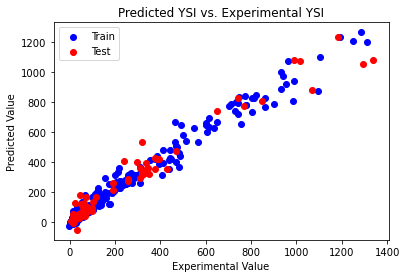

In [9]:
plt.title('Predicted YSI vs. Experimental YSI')
plt.xlabel('Experimental Value')
plt.ylabel('Predicted Value')
plt.scatter(y_train, y_train_pred, color='blue', label='Train')
plt.scatter(y_test, y_test_pred, color='red', label='Test')
plt.legend(loc='upper left')
plt.show()